In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

In [49]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
os.chdir('/content/gdrive/My Drive/placement/IIBM')
data = pd.read_csv('tumor_data.csv')
label = pd.read_csv('tumor_labels.csv')

In [53]:
feature = data.values[:,1:]
feature = np.asarray(feature).astype('float32')

#Encode the variable 

encode = preprocessing.LabelEncoder()
encode.fit(label.Class.unique())
target = encode.transform(label.Class.values)

target = np.array(target)

#encode target to categorical
target = to_categorical(target)

In [54]:
#NN model
def create_network(n_feats):
    model = Sequential()
    model.add(Dense(128, input_dim = n_feats, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    return model

In [55]:
KF = KFold(n_splits=5,shuffle=True)
itern =0
total_train_accuracy = 0
total_test_accuracy = 0
total_precision = 0
total_recall = 0
total_fscore = 0
final_conf_mat =0

for train_index, test_index in KF.split(feature):
    # Split train-test
    x_train, x_test = feature[train_index], feature[test_index]
    y_train, y_test = target[train_index], target[test_index]

    #Feature Selection with chi2 test
    ch2 = SelectKBest(chi2, k=20)
    ch2_train = ch2.fit_transform(x_train, y_train)
    ch2_test = ch2.transform(x_test)

    ### Classification model (ADD NN to be fit here)###

    classifier = create_network(ch2_train.shape[1])
    classifier.fit(ch2_train, y_train, epochs=100, batch_size=25, validation_data=(ch2_test, y_test))

    y_pred = classifier.predict(ch2_test)

    #### Scoring #####
    print ("\nAccuracy on Training Set :")
    _, accuracy_train = classifier.evaluate(ch2_train, y_train)
    print('Accuracy: %.2f' % (accuracy_train*100))
    #print("____________")
    #print (accuracy_score(inverted_y_test,inverted_y_pred))
    total_train_accuracy += accuracy_train

    print ("\nChecking on Test Set")
    print ("\nAccuracy on Testing Set :")
    _, accuracy_test = classifier.evaluate(ch2_test, y_test)
    print('Accuracy: %.2f' % (accuracy_test*100))
    total_test_accuracy += accuracy_test


    ##### Decoding the labels ####

    #inverting to_categorical encoding
    inverted_y_pred = (np.argmax(y_pred, axis=1)).reshape(-1,1)
    inverted_y_test = (np.argmax(y_test, axis=1)).reshape(-1,1)

    ###Scoring ###

    print("Fold no: "+str(itern))
    itern+=1
    
    print ("Checking on Test Set")
    print ("\nAccuracy on Testing Set :"+str(accuracy_score(inverted_y_test,inverted_y_pred)))
    #total_test_accuracy += accuracy_score(y_test,y_pred)
  
    total_precision+= precision_score(inverted_y_test, inverted_y_pred,average='macro')
    total_recall+= recall_score(inverted_y_test, inverted_y_pred,average='macro')	
    total_fscore+= f1_score(inverted_y_test, inverted_y_pred,average='macro')	
    print ("\nPrecision Score")
    print (precision_score(inverted_y_test, inverted_y_pred,average='macro'))
    print ("\nRecall Score")
    print (recall_score(inverted_y_test, inverted_y_pred,average='macro'))	
    print ("\nF1 Score")
    print (f1_score(inverted_y_test, inverted_y_pred,average='macro'))

    #Confusion Matrix
    conf_mat=confusion_matrix(inverted_y_test, inverted_y_pred)
    final_conf_mat+=conf_mat
    print("Confusion matrix :\n")
    print(conf_mat)

Epoch 1/100
26/26 [==============================] - 0s 9ms/step - loss: 1.1296 - accuracy: 0.5895 - val_loss: 0.5831 - val_accuracy: 0.9379
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5594 - accuracy: 0.9469 - val_loss: 0.4698 - val_accuracy: 0.9814
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.4172 - accuracy: 0.9778 - val_loss: 0.3942 - val_accuracy: 0.9814
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.3739 - accuracy: 0.9939 - val_loss: 0.3368 - val_accuracy: 0.9814
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.2866 - accuracy: 0.9846 - val_loss: 0.2938 - val_accuracy: 0.9814
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.2477 - accuracy: 0.9883 - val_loss: 0.2607 - val_accuracy: 0.9814
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.2070 - accuracy: 0.9918 - val_loss: 0.2335 - val_accuracy: 0.9814
Epoch 8/100
2

Mean train accuracy : 99.72
Mean test accuracy : 98.88
Mean precision : 99.35
Mean recall : 98.52
Mean fscore : 98.91
Confusion matrix : 
[[299   0   0   1   0]
 [  1  77   0   0   0]
 [  2   0 144   0   0]
 [  5   0   0 136   0]
 [  0   0   0   0 136]]


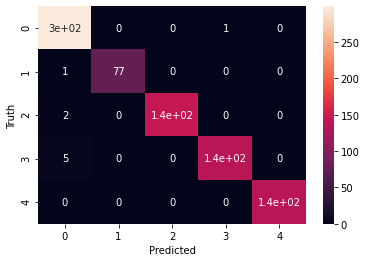

In [57]:
print("Mean train accuracy : %.2f" % ((total_train_accuracy/5)*100))
print("Mean test accuracy : %.2f" % ((total_test_accuracy/5)*100))
print("Mean precision : %.2f" % ((total_precision/5)*100))
print("Mean recall : %.2f" % ((total_recall/5)*100))
print("Mean fscore : %.2f" % ((total_fscore/5)*100))

print("Confusion matrix : " )
print(final_conf_mat)
#plt.figure(figsize=(5,5))
sns.heatmap(final_conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()